# Skinspect: Skin Tumor Classification
Detects whether tumor is benign or not

In [ ]:
#imports
import os
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.efficientnet import EfficientNetB3

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

import warnings
warnings.filterwarnings("ignore")

# Optional: Kaggle Installation

[Kaggle Dataset for Skin Cancer: Malignant vs. Benign](https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign)

if you already have data in a zip folder ur good then skip

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download fanconic/skin-cancer-malignant-vs-benign

/bin/bash: line 1: kaggle: command not found


# Unzip Method
if already have images in folders unzipped, skip

just call the zip 'skin-cancer-malignant-vs-benign.zip'

In [ ]:
#unzip
from zipfile import ZipFile
file_name = '/content/skin-cancer-malignant-vs-benign.zip'
with open('/content/skin-cancer-malignant-vs-benign.zip', 'rb') as MyZip:
  print(MyZip.read(4))
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

FileNotFoundError: ignored

# Path Setting for Training and Testing
putting unzipped data into training and testing split folders

In [ ]:
#file path for training
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [ ]:
#file path for testing
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [ ]:
train_df = train_df('/content/data/train')
test_df = test_df('/content/data/test')

# Pre-Processing Data
Setting hyper-parameters for training model and putting imgs into gens

In [ ]:
#Split into vaild and test sets
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [ ]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (224, 224, 3)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col= 'Class Path', y_col= 'Class', target_size= img_size, class_mode = 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col= 'Class Path', y_col= 'Class', target_size= img_size, class_mode = 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col= 'Class Path', y_col= 'Class', target_size= img_size, class_mode = 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


# Optional: Plotting Train Data
just looking at train data and plotting to see if loaded into gen properly

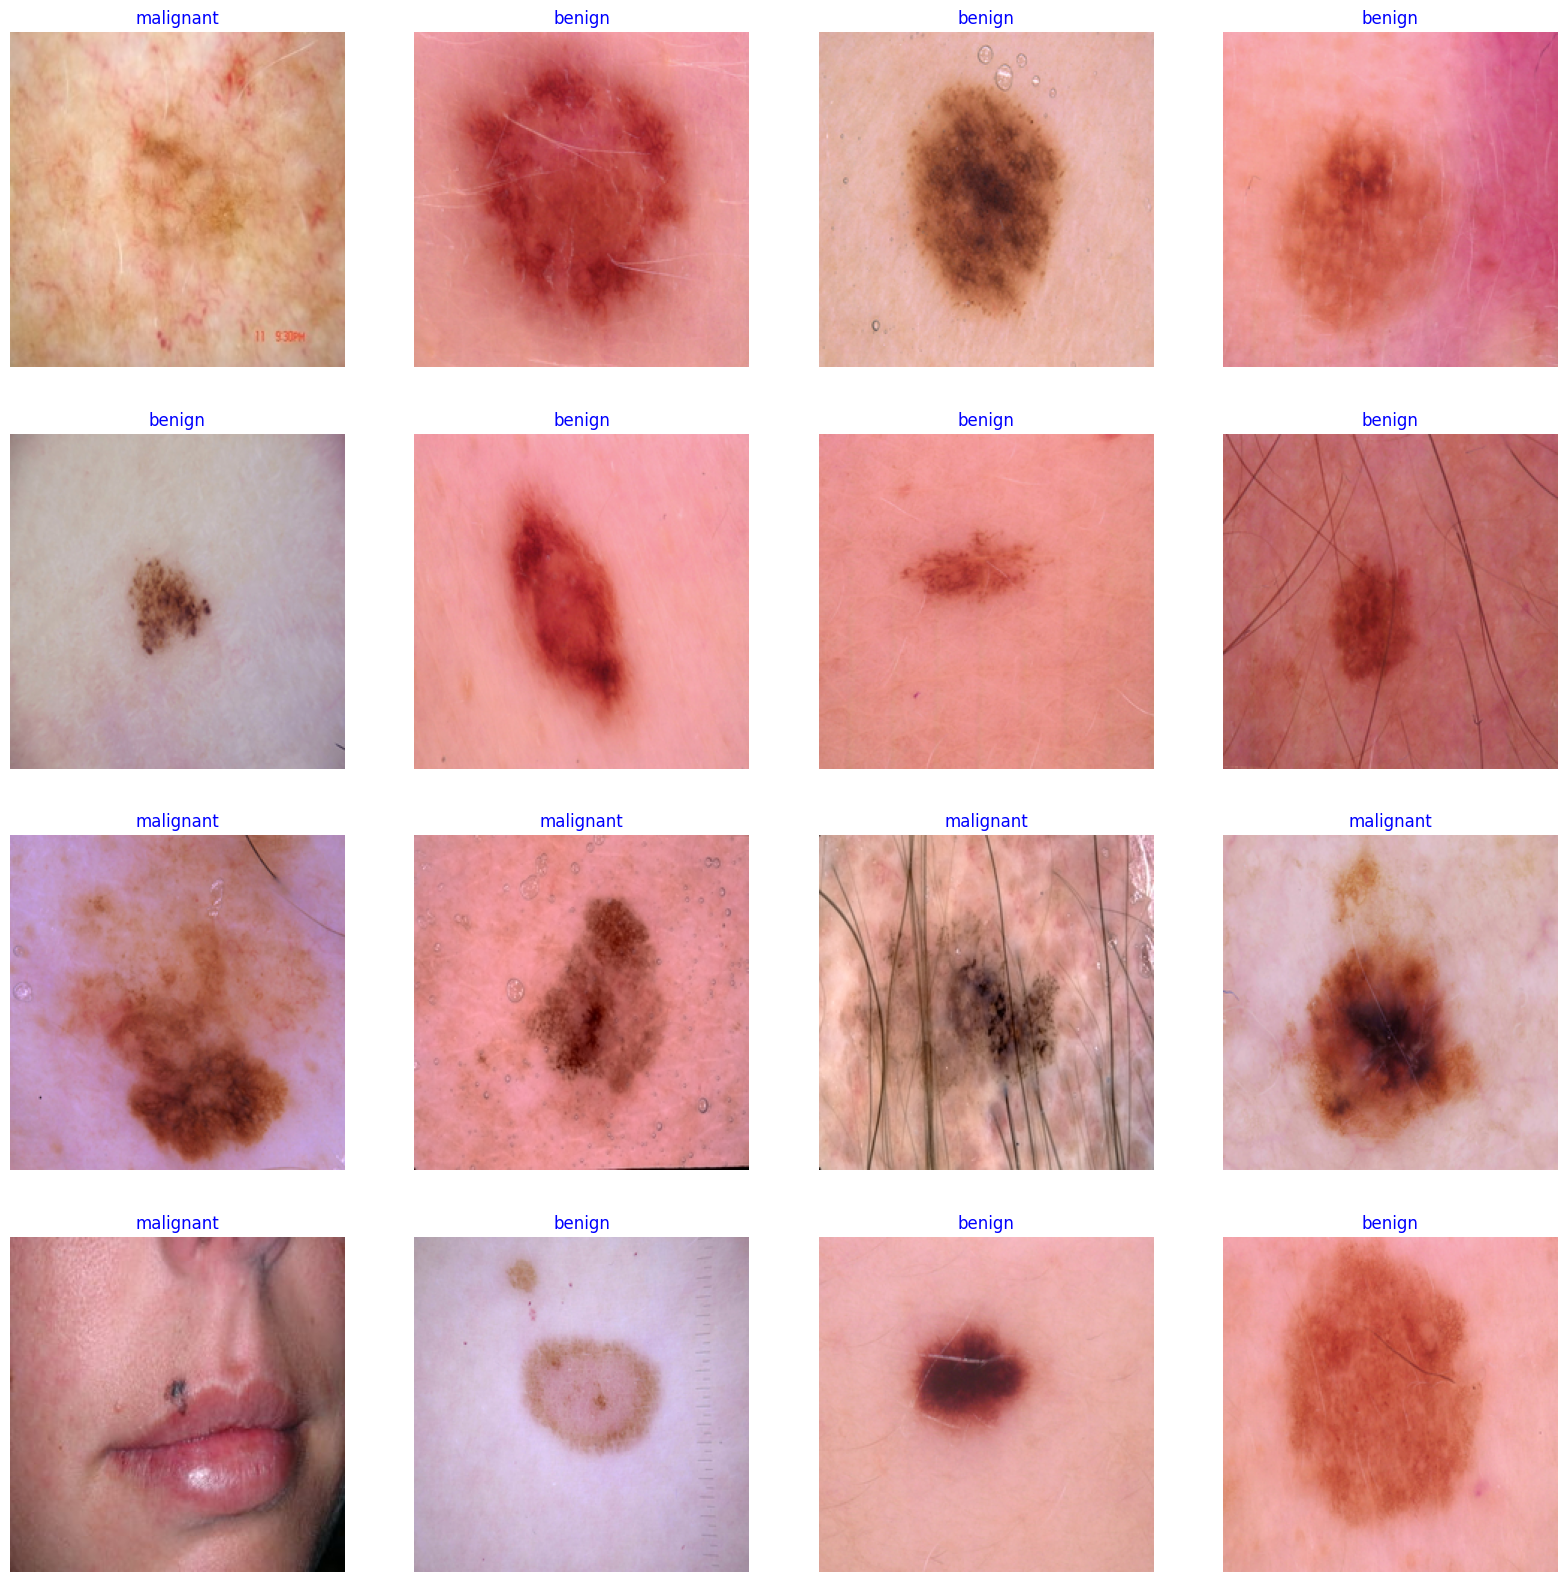

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# The Model
used basic CNN with Sequential, look to use vgg18 or resnet50

In [ ]:
#Build and train a CNN
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_gen, steps_per_epoch=len(train_gen), validation_data = valid_gen, validation_steps=len(valid_gen), epochs=10, verbose=1)

Epoch 1/10
83/83 [==============================] - 228s 3s/step - loss: 43.1111 - accuracy: 0.6200 - val_loss: 6.5376 - val_accuracy: 0.7576
Epoch 2/10
83/83 [==============================] - 215s 3s/step - loss: 4.3676 - accuracy: 0.7527 - val_loss: 4.8271 - val_accuracy: 0.7182
Epoch 3/10
83/83 [==============================] - 214s 3s/step - loss: 3.2920 - accuracy: 0.7463 - val_loss: 2.1086 - val_accuracy: 0.8000
Epoch 4/10
83/83 [==============================] - 221s 3s/step - loss: 3.2029 - accuracy: 0.7592 - val_loss: 2.5198 - val_accuracy: 0.7879
Epoch 6/10
83/83 [==============================] - 221s 3s/step - loss: 2.4162 - accuracy: 0.7687 - val_loss: 2.6303 - val_accuracy: 0.7515
Epoch 7/10
83/83 [==============================] - 214s 3s/step - loss: 2.7867 - accuracy: 0.7728 - val_loss: 3.3272 - val_accuracy: 0.7424
Epoch 8/10
83/83 [==============================] - 215s 3s/step - loss: 1.7162 - accuracy: 0.7926 - val_loss: 1.5321 - val_accuracy: 0.7818
Epoch 9/10
8

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

11/11 [==============================] - 10s 876ms/step - loss: 3.0576 - accuracy: 0.7758
Train Loss:  1.8782774209976196
Train Accuracy:  0.828972339630127
--------------------
Validation Loss:  2.5682380199432373
Validation Accuracy:  0.7939394116401672
--------------------
Test Loss:  3.0575547218322754
Test Accuracy:  0.7757575511932373


In [ ]:
model.save('/content/model_skin_cancer.h5')

NameError: ignored

In [ ]:
model_name = model.input_names[0][:-1]
subject = 'Skin Tumor Classification'
acc = test_score[1] * 100
save_path = '/content/'

weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

weights were saved as /content/conv2d_inpu-Skin Tumor Classification-weights.h5


In [ ]:
def load_model():
    model=tf.keras.models.load_model('/content/model_skin_cancer.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()

NameError: ignored

# The Web App
Used Streamlit for front-end and created simple web app with drag&drop file input

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

# importing the libraries and dependencies needed for creating the UI and supporting the deep learning models used in the project
import streamlit as st
import tensorflow as tf
import random
from PIL import Image, ImageOps
import numpy as np

# hide deprication warnings which directly don't affect the working of the application
import warnings
warnings.filterwarnings("ignore")

# set some pre-defined configurations for the page, such as the page title, logo-icon, page loading state (whether the page is loaded automatically or you need to perform some action for loading)
st.set_page_config(
    page_title="SkinSpect: Skin Tumor Malignant or Benign Detection",
    page_icon = ":smile:",
    initial_sidebar_state = 'auto'
)

# hide the part of the code, as this is just for adding some custom CSS styling but not a part of the main idea
hide_streamlit_style = """
	<style>
  #MainMenu {visibility: hidden;}
	footer {visibility: hidden;}
  </style>
"""
st.markdown(hide_streamlit_style, unsafe_allow_html=True) # hide the CSS code from the screen as they are embedded in markdown text. Also, allow streamlit to unsafely process as HTML

def prediction_cls(prediction): # predict the class of the images based on the model results
    for key, clss in class_names.items(): # create a dictionary of the output classes
        if np.argmax(prediction)==clss: # check the class

            return key

with st.sidebar:
        st.title("SkinSpect: Malignant or Benign")
        st.subheader("Accurate detection of skin tumor whether it is benign or malignant")
        st.subheader("Benign means non-cancerous. Benign skin tumors do not invade nearby tissues or spread to other parts of the body.")
        st.subheader("Malignant means cancerous. Malignant skin tumors have the potential to invade surrounding tissues and, if not treated early, may spread (metastasize) to other parts of the body.")

st.write("""
         # Skin Tumor Classification
         """
         )

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache_data
def load_model():
    model=tf.keras.models.load_model('/content/model_skin_cancer.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()

file = st.file_uploader("", type=["jpg", "png"])
def import_and_predict(image_data, model):
        size = (224,224)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        img = np.asarray(image)
        img_reshape = img[np.newaxis,...]
        prediction = model.predict(img_reshape)
        return prediction


if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    x = random.randint(98,99)+ random.randint(0,99)*0.01
    st.sidebar.error("Accuracy : " + str(x) + " %")

    class_names = ['benign', 'malignant']

    string = "Detected Tumor : " + class_names[np.argmax(predictions)]
    if class_names[np.argmax(predictions)] == 'benign':
        st.balloons()
        st.sidebar.success(string)
        st.info("Your tumor is benign, so it is safe! It is not malignant so it is not cancerous.")
        st.info("Our recommendation would be to still get it checked out and tested!")

    elif class_names[np.argmax(predictions)] == 'malignant':
        st.sidebar.warning(string)
        st.markdown("## Malignant Tumor Detected")
        st.info("Seek medical attention ASAP. Your tumor has cancerous cells!")
        st.info("Malignant tumors are cancerous and can spread cancer cells throughout one's body through the blood or lymphatic system, a process known as metastasis")
        st.info("Treatment options may include surgery, chemotherapy or radiation therapy. Early detection is key, so be sure to attend all recommended cancer screenings.")

Writing app.py


In [ ]:
st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache_data
def load_model():
    model=tf.keras.models.load_model('/content/model_skin_cancer.h5')
    return model
with st.spinner('Model is being loaded..'):
    model=load_model()

NameError: ignored

In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.664s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



   ╭────────────────────────────────────────────────────────────────╮
   │                                                                │
   │      New major version of npm available! 6.14.8 → 10.2.0       │
   │   Changelog: https://github.com/npm/cli/releases/tag/v10.2.0   │
   │               Run npm install -g npm to update!                │
   │                                                                │
   ╰────────

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.196.225.130
npx: installed 22 in 3.83s
your url is: https://four-meals-grab.loca.lt


In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 3.303s
your url is: https://slow-adults-start.loca.lt
^C
